In [10]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

# linear Koopman
from core.koopman_core_linear import KoopDNN as KoopDNN
from core.koopman_core_linear import KoopmanNet as KoopmanNet
from core.koopman_core_linear import KoopmanNetCtrl as KoopmanNetCtrl
from core.adapt_net_lin import AdaptNet_lin



from models.koop_model import model_matricies,lift
from dynamics.robot_3R import dynamics_3R
from dynamics.Vanpol import dynamics_vanpol

import control as ct

In [2]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

In [3]:
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

#dynamic friction coefficient
robot_pars['fd'] = 0.1

In [4]:
X_end,X_full, U_full = dynamics_3R(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)
print(X_end.shape, X_full.shape,U_full.shape)

(125, 1001, 2) (125, 1001, 6) (125, 1000, 3)


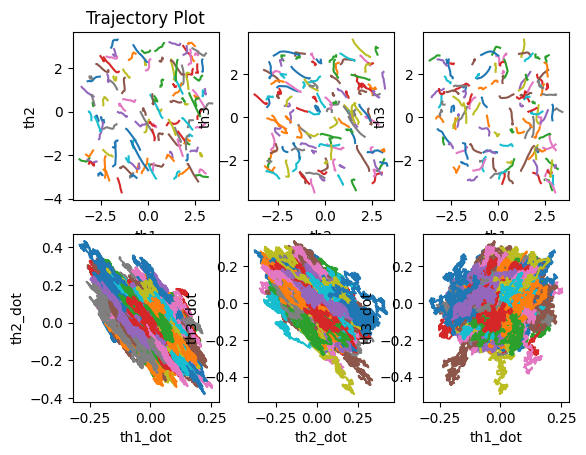

In [5]:
"""Training dataset visualization"""
#theta1 theta2 plot
plt.subplot(2,3,1)
plt.title("Trajectory Plot")
plt.xlabel("th1")
plt.ylabel("th2")
for i in range(num_traj):
  plt.plot(X_full[i,:,0],X_full[i,:,1])

#theta2 theta3 plot
plt.subplot(2,3,2)
plt.xlabel("th2")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,1],X_full[i,:,2])

#theta1 theta3 plot
plt.subplot(2,3,3)
plt.xlabel("th1")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,0],X_full[i,:,2])

#theta1_dot theta2_dot plot
plt.subplot(2,3,4)
plt.xlabel("th1_dot")
plt.ylabel("th2_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,4])

#theta2_dot theta3_dot plot
plt.subplot(2,3,5)
plt.xlabel("th2_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,4],X_full[i,:,5])

#theta1_dot theta3_dot plot
plt.subplot(2,3,6)
plt.xlabel("th1_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,5])



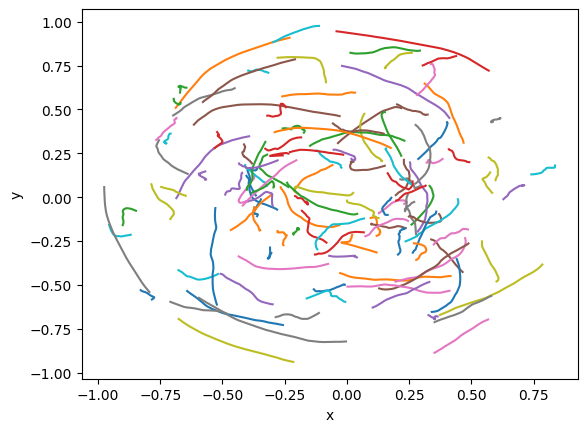

In [6]:
#x and y positions of the end effector

plt.xlabel("x")
plt.ylabel("y")
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])

In [7]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [12]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 10
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 4e-4 # 5e-4
net_params['epochs'] = 2000
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [13]:
train = True

if train == True:
    file = 'saved_models/learned_models/linear_model/robot_3r_lin.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'saved_models/learned_models/linear_model/robot_3r_lin.pth'
    model_koop_dnn = torch.load(file)

Epoch   1: train loss: 1.0404229164, validation loss: 0.8886661422
Epoch   2: train loss: 0.6961566210, validation loss: 0.6295444275
Epoch   3: train loss: 0.4540104866, validation loss: 0.3933867988
Epoch   4: train loss: 0.2577397525, validation loss: 0.1972809542
Epoch   5: train loss: 0.1064249128, validation loss: 0.0634430963
Epoch   6: train loss: 0.0344932377, validation loss: 0.0187715935
Epoch   7: train loss: 0.0098646982, validation loss: 0.0053201535
Epoch   8: train loss: 0.0027098728, validation loss: 0.0017788717
Epoch   9: train loss: 0.0009209134, validation loss: 0.0009547109
Epoch  10: train loss: 0.0005332040, validation loss: 0.0007301955
Epoch  11: train loss: 0.0004121317, validation loss: 0.0005895718
Epoch  12: train loss: 0.0003397791, validation loss: 0.0004981976
Epoch  13: train loss: 0.0002894464, validation loss: 0.0004177641
Epoch  14: train loss: 0.0002531226, validation loss: 0.0003721838
Epoch  15: train loss: 0.0002263133, validation loss: 0.000331

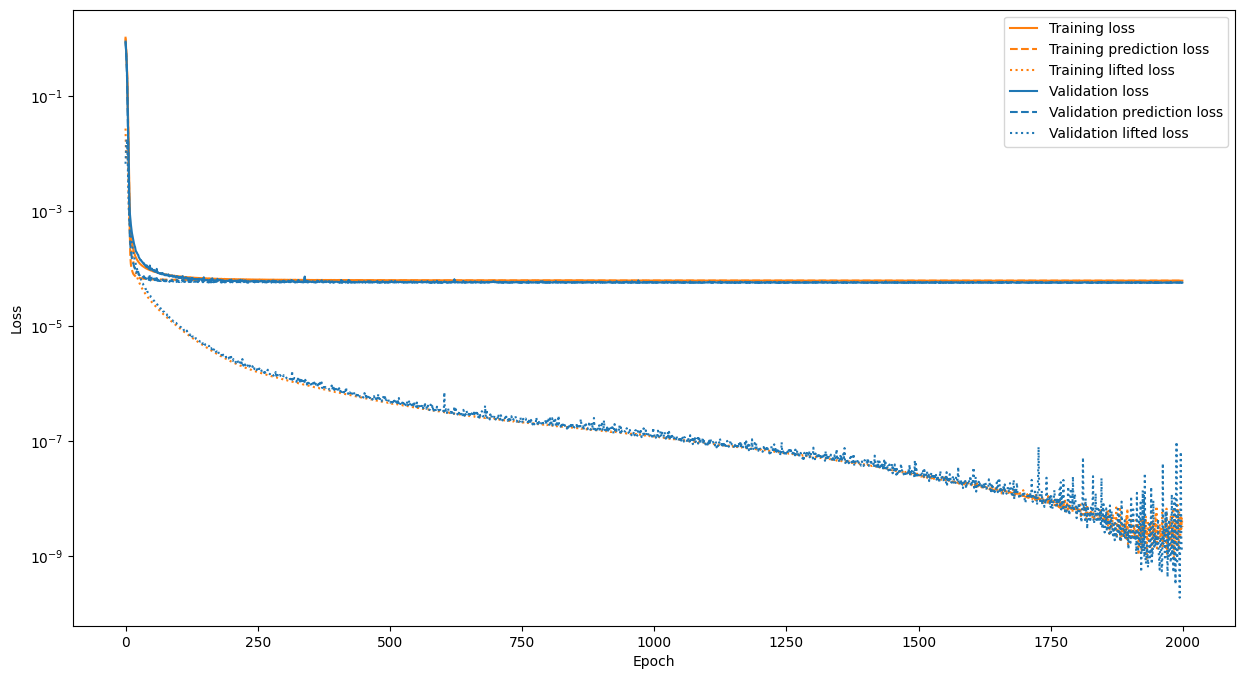

In [15]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Linear Model

In [16]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(17, 17) (17, 3) (6, 17)


## Controllability

In [19]:
#check controllability
Con_lin = ct.ctrb(A, B)
rank_lin = np.linalg.matrix_rank(Con_lin)

print(rank_lin)

14


## Testing

In [20]:
# test data parameters
num_snaps_val = 2000 # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

In [22]:
xs_end_test,xs_test, us_test = dynamics_3R(dt,num_traj_val, num_snaps_val,num_states,num_inputs, robot_pars)
print(model_koop_dnn.test_loss(xs_test,u_test = us_test))

tensor(2.7832e-05)


In [25]:
X,_ = model_koop_dnn.net.process(xs_test,data_u = us_test)
print(X.shape)

(2000, 15)


In [27]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(2000, 6) (2000, 3) (2000, 6)


In [29]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T

z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

## Time Evolution

In [31]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)   

## Joint Space Evolution

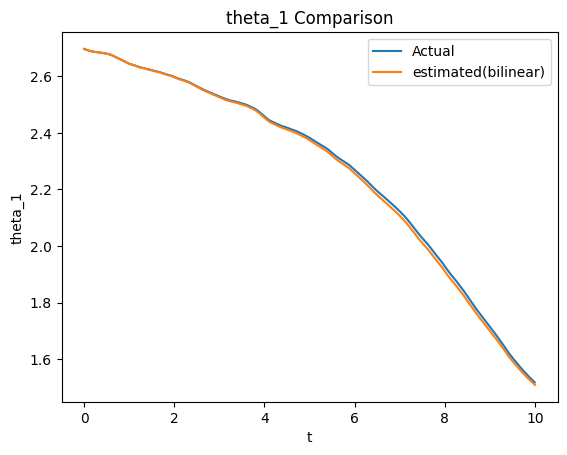

In [33]:
plt.figure()
plt.plot(T[:-1],x[:,0],label ='Actual')
plt.plot(T,x_est[:,0],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

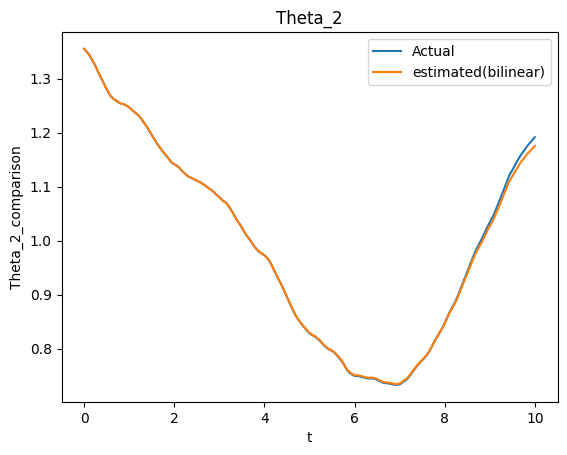

In [34]:
plt.figure()
plt.plot(T[:-1],x[:,1],label ='Actual')
plt.plot(T,x_est[:,1],label = 'estimated(bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

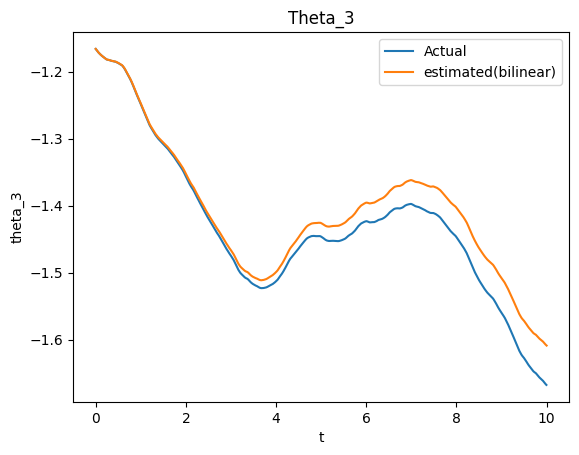

In [35]:

plt.figure()
plt.plot(T[:-1],x[:,2],label ='Actual')
plt.plot(T,x_est[:,2],label = 'estimated(bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

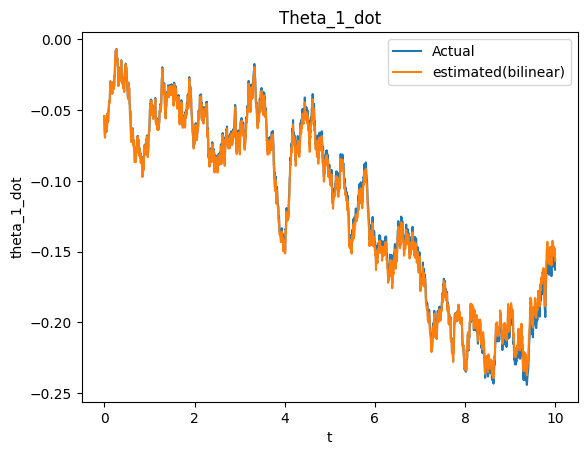

In [36]:
plt.figure()
plt.plot(T[:-1],x[:,3],label ='Actual')
plt.plot(T,x_est[:,3],label = 'estimated(bilinear)')
plt.title('Theta_1_dot')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.legend()

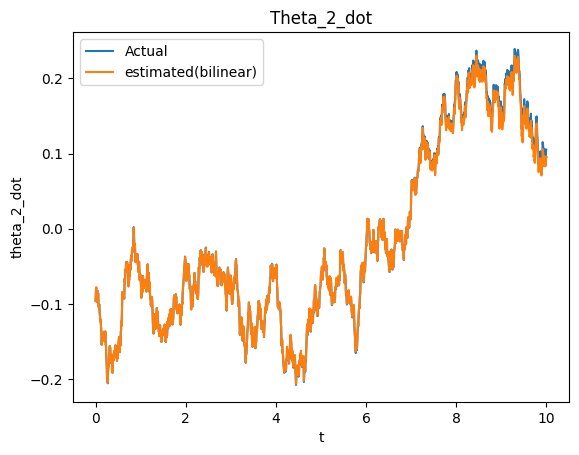

In [37]:
plt.figure()
plt.plot(T[:-1],x[:,4],label ='Actual')
plt.plot(T,x_est[:,4],label = 'estimated(bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('theta_2_dot')
plt.legend()

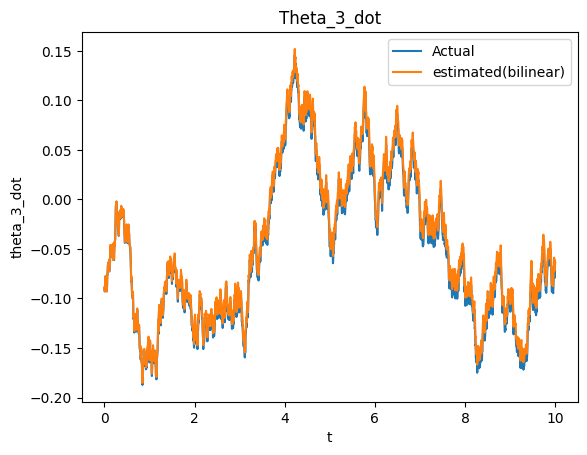

In [38]:
plt.figure()
plt.plot(T[:-1],x[:,5],label ='Actual')
plt.plot(T,x_est[:,5],label = 'estimated(bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()